In [184]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples=100_000,
    n_features=20,
    n_informative=2,
    n_redundant=10,
    random_state=42,
    weights=[0.95, 0.05],
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.99, random_state=42
)

In [185]:
y_test.sum() / y_test.shape[0]

0.05484848484848485

In [186]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.naive_bayes import GaussianNB

lr = LogisticRegression(C=1.0)
gnb = GaussianNB()
gnb_isotonic = CalibratedClassifierCV(gnb, cv=2, method="isotonic")
gnb_sigmoid = CalibratedClassifierCV(gnb, cv=2, method="sigmoid")
ls = Lasso()

clf_list = [
    (lr, "Logistic"),
    (gnb, "Naive Bayes"),
    # (ls, "Lasso"),
    (gnb_isotonic, "Naive Bayes + Isotonic"),
    (gnb_sigmoid, "Naive Bayes + Sigmoid"),
]

In [187]:
CalibrationDisplay.from_predictions

<bound method CalibrationDisplay.from_predictions of <class 'sklearn.calibration.CalibrationDisplay'>>

Logistic ROC AUC: 0.89
Naive Bayes ROC AUC: 0.90
Naive Bayes + Isotonic ROC AUC: 0.90
Naive Bayes + Sigmoid ROC AUC: 0.90


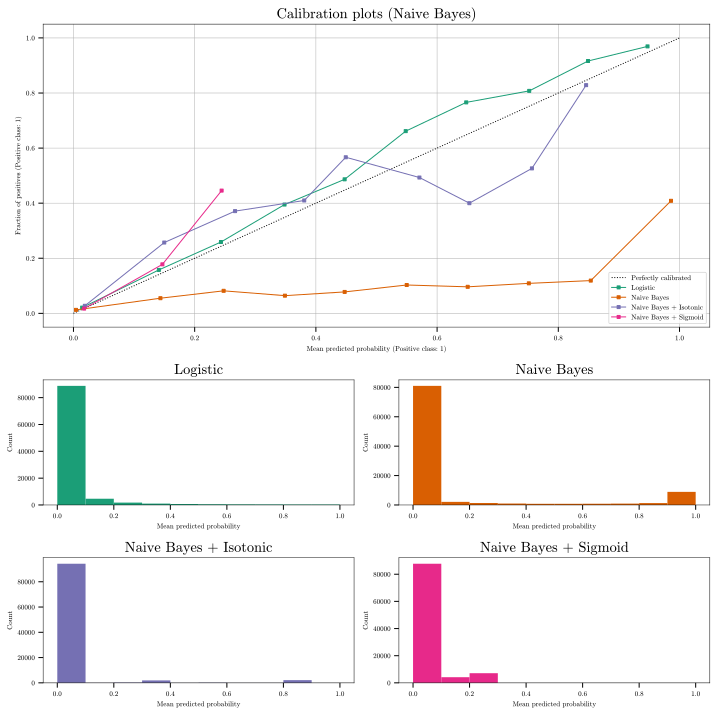

In [188]:
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    from sklearn.metrics import roc_auc_score

    roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
    print(f"{name} ROC AUC: {roc_auc:.2f}")
    display = CalibrationDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots (Naive Bayes)")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

In [67]:
from collections import defaultdict

import pandas as pd

from sklearn.metrics import (
    brier_score_loss,
    f1_score,
    log_loss,
    precision_score,
    recall_score,
    roc_auc_score,
)

scores = defaultdict(list)
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    y_prob = clf.predict_proba(X_test)
    y_pred = clf.predict(X_test)
    scores["Classifier"].append(name)

    for metric in [brier_score_loss, log_loss, roc_auc_score]:
        score_name = metric.__name__.replace("_", " ").replace("score", "").capitalize()
        scores[score_name].append(metric(y_test, y_prob[:, 1]))

    for metric in [precision_score, recall_score, f1_score]:
        score_name = metric.__name__.replace("_", " ").replace("score", "").capitalize()
        scores[score_name].append(metric(y_test, y_pred))

    score_df = pd.DataFrame(scores).set_index("Classifier")
    score_df.round(decimals=3)

score_df

,Brier loss,Log loss,Roc auc,Precision,Recall,F1
Classifier,,,,,,
Logistic,0.073788,0.249484,0.933248,0.801643,0.674273,0.732462
Naive Bayes,0.108184,0.709852,0.934998,0.651785,0.833955,0.731702
Naive Bayes + Isotonic,0.074456,0.281395,0.932893,0.808694,0.664082,0.729288
Naive Bayes + Sigmoid,0.083588,0.283152,0.935238,0.705848,0.789610,0.745383


## 使用自己的数据测试

In [166]:
import pandas as pd

import statsmodels.api as sm
import pandas as pd
import datetime
from pathlib import Path

pd.set_option("display.max_columns", None)
# !pip install statsmodels


# %config InlineBackend.figure_format = "svg"
# %config InlineBackend.print_figure_kwargs = {"dpi" : 300}
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


# from cadFace.vis import percentiles_plot
import sci_palettes

try:
    sci_palettes.register_cmap()
except:
    pass
import scienceplots
from pathlib import Path
import pandas as pd
from ppp_aging.ppp_model import *

plt.style.use(["nature", "no-latex"])
sns.set_context("paper", font_scale=1.5)
sns.set_palette("nejm")
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
import scienceplots

plt.style.use(["nature", "no-latex"])

/tmp/ipykernel_7193/4284081116.py:36: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


In [167]:
test_score = pd.read_csv("_resultv2/part2/test_score.csv")
train_score = pd.read_csv("_resultv2/part2/train_score.csv")

In [168]:
from sklearn.calibration import (
    CalibratedClassifierCV,
    CalibrationDisplay,
    calibration_curve,
)

from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression


def calibration_score(
    raw_train_pred, raw_test_pred, train_y, test_y, method="isotonic"
):
    if method == "isotonic":
        ir = IsotonicRegression(out_of_bounds="clip")
        ir.fit(raw_train_pred, train_y)

        pred_train_calibrated = ir.predict(raw_train_pred)
        pred_test_calibrated = ir.predict(raw_test_pred)
    elif method == "logitstic":
        lr = LogisticRegression(
            # class_weight="balanced",
            max_iter=1000,
            random_state=42,
        )
        raw_train_pred = (
            raw_train_pred.values
            if isinstance(raw_train_pred, pd.Series)
            else raw_train_pred
        )
        raw_test_pred = (
            raw_test_pred.values
            if isinstance(raw_test_pred, pd.Series)
            else raw_test_pred
        )
        lr.fit(raw_train_pred.reshape(-1, 1), train_y)
        pred_train_calibrated = lr.predict_proba(raw_train_pred.reshape(-1, 1))[:, 1]
        pred_test_calibrated = lr.predict_proba(raw_test_pred.reshape(-1, 1))[:, 1]
    else:
        raise ValueError("method should be isotonic or logitstic")

    return pred_train_calibrated, pred_test_calibrated

In [169]:
test_score

,eid,PRS,sex,height,weight,BSA,genotype_array,age,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,assessment_center,age_squared,BMI,dbp_a,sbp_a,tc_a,tg_a,hdl_a,ldl_a,dbp,sbp,tc,tg,hdl,ldl,apob,cad,mi,crp,eGFR,Cr,CAD,cad_date,birth_date,recuit_date,death_date,cad_age,death_age,recuit_age,year_of_cad_after_recuit,survival_time,is_earily_CAD,incident_cad,cad_status,prevalent_cad,smoking,prevalent_diabetes,Arrhythmia,Stroke,Peripheral_vascular_disease,Hypertension,future_cad_time_days,future_cad_time_months,future_cad_time_years,proteomicsRS,SigAssocRS,EnsembleProtRS,PRS + RF,PRS + AS,SigAssocRS + RF,SigAssocRS + AS,SigAssocRS + RF + PRS,proteomicsRS + RF,proteomicsRS + AS,proteomicsRS + RF + PRS,EnsembleProtRS + RF,EnsembleProtRS + AS,EnsembleProtRS + RF + PRS,RF,AS,RF_without_AS
0,2883530.0,1.030583,1.0,171.0,64.2,1.746282,2,44.0,71.3002,-100.66700,81.855800,9.994410,-0.516576,4.576150,1.832860,5.045020,1.614310,18.488800,4,1936.0,21.9555,76.0,115.000000,5.851000,0.893000,1.635000,3.549000,76.0,115.0,5.851,0.893,1.635,3.549,1.002,0,0,0.48,112.310853,69.9,0,NaN,1965-07-01,2010-06-18,NaN,NaN,NaN,44.994521,NaN,NaN,NaN,0.0,control,0.0,0.0,0.0,0,0,0,0,5045 days 10:14:40.562038,169.0,14.0,0.067694,0.118559,0.074782,0.004710,0.043320,0.107093,0.118591,0.111727,0.066771,0.068603,0.070986,0.080357,0.076001,0.084278,-0.003829,0.039190,9.517893
1,2867444.0,2.192278,0.0,165.0,55.8,1.599219,2,53.0,-12.4815,3.16181,-3.999700,0.309314,-6.865420,-1.982800,-1.245250,1.828070,-4.040440,-0.823290,11,2809.0,20.4959,100.0,150.000000,7.407000,3.176000,1.415000,4.840000,100.0,150.0,7.407,3.176,1.415,4.840,1.433,0,0,1.32,82.185961,74.9,0,NaN,1955-11-01,2009-04-15,NaN,NaN,NaN,53.490411,NaN,NaN,NaN,0.0,control,0.0,0.0,0.0,0,0,0,0,5474 days 10:14:40.547041,183.0,15.0,0.034012,0.069739,0.076758,0.082868,0.087514,0.074116,0.065538,0.123503,0.042133,0.031046,0.093734,0.089410,0.078090,0.133772,0.022978,0.019502,11.872159
2,5869793.0,0.653794,1.0,171.0,77.3,1.916181,2,62.0,-11.4721,2.20519,0.205421,-1.035540,-2.391010,-2.383070,0.886641,-0.934631,1.414580,1.704540,9,3844.0,26.4355,81.0,144.000000,5.909000,1.869000,1.670000,3.587000,81.0,144.0,5.909,1.869,1.670,3.587,1.025,0,0,1.93,85.913239,87.7,0,NaN,1947-10-01,2010-01-19,NaN,NaN,NaN,62.345205,NaN,NaN,NaN,0.0,control,0.0,0.0,0.0,0,0,0,0,5195 days 10:14:43.101214,174.0,15.0,0.069303,0.068507,0.085926,0.054371,0.080166,0.064285,0.071763,0.051206,0.066977,0.070396,0.052764,0.085088,0.087784,0.073206,0.069679,0.103383,11.948630
3,4880838.0,0.664819,0.0,163.0,84.4,1.954852,2,62.0,-11.1640,3.66252,-5.106300,2.058800,0.185104,-1.089780,0.567691,-2.982090,-11.959100,-1.167040,12,3844.0,31.7663,87.0,128.000000,5.603000,1.184000,1.451221,3.394000,87.0,128.0,5.603,1.184,NaN,3.394,1.029,0,0,3.57,71.698114,80.1,0,NaN,1945-06-01,2008-05-28,NaN,NaN,NaN,63.032877,NaN,NaN,NaN,0.0,control,0.0,1.0,0.0,0,0,0,0,5796 days 10:14:42.268467,194.0,16.0,0.009363,0.016679,-0.055559,0.032731,0.033944,0.010047,0.014954,-0.004025,-0.008451,0.003562,-0.021815,-0.074932,-0.061814,-0.085979,0.046213,0.051599,11.212028
4,3987428.0,0.826465,0.0,164.0,73.1,1.824859,1,66.0,-11.4666,2.77498,-0.076815,1.956800,-3.117790,1.036540,-0.677142,-1.716000,-5.479400,1.998590,8,4356.0,27.1788,82.0,124.000000,5.887954,1.797038,1.451221,3.752458,82.0,124.0,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,0,NaN,1942-07-01,2009-03-30,NaN,NaN,NaN,66.791781,NaN,NaN,NaN,0.0,control,0.0,0.0,0.0,0,0,0,0,5490 days 10:14:41.520976,183.0,16.0,0.105304,0.171897,0.149259,0.039309,0.055324,0.155225,0.165760,0.147256,0.102883,0.110538,0.095046,0.154897,0.154750,0.148183,0.047785,0.065864,10.562647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15427,5241912.0,1.085083,1.0,176.0,116.0,2.381409,2,45.0,-10.8083,4.46241,-3.4077

In [170]:
def plot_calibration_score(
    fraction_of_positives, mean_predicted_value, name="unk", ax=None, line_kwargs=None
):
    if ax is None:
        fig, ax = plt.subplots()
    up_bd = max([max(fraction_of_positives), max(mean_predicted_value)])

    line_kwargs_default = dict(marker="o")
    if line_kwargs is not None:
        line_kwargs_default.update(line_kwargs)

    ax.plot(
        mean_predicted_value, fraction_of_positives, label=name, **line_kwargs_default
    )

    ax.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    ax.set(
        title="Calibration plot",
        xlabel="Mean predicted value",
        ylabel="Fraction of positives",
    )
    print(up_bd)
    ax.set_xlim(0, up_bd)
    ax.set_ylim(0, up_bd)
    ax.legend()
    return ax

0.22262715172878736
0.20854922279792745


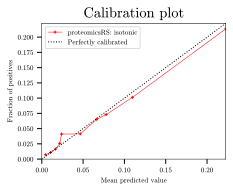

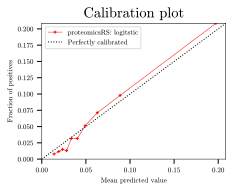

In [172]:
from sklearn.calibration import calibration_curve

for method in ["proteomicsRS"]:
    # calibration
    train_pred = train_score[f"{method}"]
    test_pred = test_score[f"{method}"]
    y_train = train_score["incident_cad"]
    y_test = test_score["incident_cad"]

    for calibration_method in ["isotonic", "logitstic"]:
        fig, ax = plt.subplots()
        train_score[f"{method}:calibrated"], test_score[f"{method}:calibrated"] = (
            calibration_score(
                train_pred, test_pred, y_train, y_test, method=calibration_method
            )
        )
        fraction_of_positives, mean_predicted_value = calibration_curve(
            test_score["incident_cad"],
            test_score[f"{method}:calibrated"],
            n_bins=10,
            strategy="quantile",
        )
        plot_calibration_score(
            fraction_of_positives,
            mean_predicted_value,
            name=f"{method}: {calibration_method}",
            ax=ax,
            line_kwargs={"marker": "+", "lw": 0.5, "color": "red"},
        )

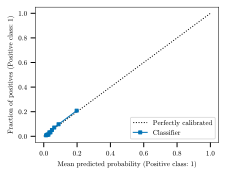

In [173]:
CalibrationDisplay.from_predictions(
    y_true=y_test,
    y_prob=pred_test_calibrated,
    n_bins=10,
    strategy="quantile",
)

In [110]:
# install dcurves to perform DCA (first install package via pip)
# pip install dcurves
from dcurves import dca, plot_graphs

# install other packages used in this tutorial
# pip install pandas numpy statsmodels lifelines
import pandas as pd
import numpy as np
import statsmodels.api as sm
import lifelines

In [112]:
df_cancer_dx = pd.read_csv(
    "https://raw.githubusercontent.com/ddsjoberg/dca-tutorial/main/data/df_cancer_dx.csv"
)
df_cancer_dx

,patientid,cancer,risk_group,age,famhistory,marker,cancerpredmarker
0,1,0,low,64.03445,0,0.776309,0.037201
1,2,0,high,78.46741,0,0.267086,0.578907
2,3,0,low,64.14617,0,0.169621,0.021551
3,4,0,low,58.53482,0,0.023996,0.003910
4,5,0,low,63.99250,0,0.070910,0.018790
...,...,...,...,...,...,...,...
745,746,0,intermediate,66.09628,0,0.654782,0.057813
746,747,1,intermediate,65.75370,1,1.030259,0.160424
747,748,0,intermediate,70.28287,0,0.151616,0.108838
748,749,0,low,61.32673,0,0.624602,0.015285


In [113]:
mod1 = sm.GLM.from_formula('cancer ~ famhistory', data=df_cancer_dx, family=sm.families.Binomial())
mod1_results = mod1.fit()

print(mod1_results.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                 cancer   No. Observations:                  750
Model:                            GLM   Df Residuals:                      748
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -301.30
Date:                Mon, 15 Apr 2024   Deviance:                       602.60
Time:                        17:22:49   Pearson chi2:                     750.
No. Iterations:                     4   Pseudo R-squ. (CS):           0.006445
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.9227      0.119    -16.163      0.0

,model,threshold,n,prevalence,harm,test_pos_rate,tp_rate,fp_rate,net_benefit,net_intervention_avoided
0,famhistory,0.00,750,0.14,0.0,0.153333,0.032,0.121333,0.032000,-inf
1,famhistory,0.01,750,0.14,0.0,0.153333,0.032,0.121333,0.030774,-9.953333
2,famhistory,0.02,750,0.14,0.0,0.153333,0.032,0.121333,0.029524,-4.553333
3,famhistory,0.03,750,0.14,0.0,0.153333,0.032,0.121333,0.028247,-2.753333
4,famhistory,0.04,750,0.14,0.0,0.153333,0.032,0.121333,0.026944,-1.853333
...,...,...,...,...,...,...,...,...,...,...
295,none,0.95,750,0.14,0.0,0.000000,0.000,0.000000,0.000000,0.852632
296,none,0.96,750,0.14,0.0,0.000000,0.000,0.000000,0.000000,0.854167
297,none,0.97,750,0.14,0.0,0.000000,0.000,0.000000,0.000000,0.855670
298,none,0.98,750,0.14,0.0,0.000000,0.000,0.000000,0.000000,0.857143


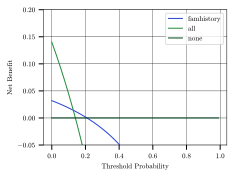

In [115]:
dca_famhistory_df = dca(data=df_cancer_dx, outcome="cancer", modelnames=["famhistory"])

plot_graphs(plot_df=dca_famhistory_df, graph_type="net_benefit", y_limits=[-0.05, 0.2])

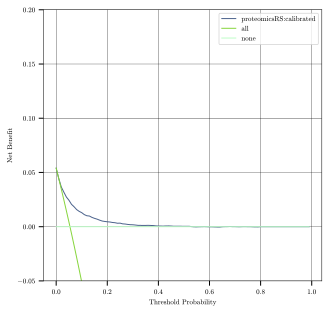

In [132]:
fig, ax = plt.subplots(figsize=(5, 5))
dca_famhistory_df = dca(
    data=test_score,
    outcome="incident_cad",
    modelnames=["proteomicsRS:calibrated"],
)
dca_famhistory_df
plot_graphs(
    plot_df=dca_famhistory_df,
    graph_type="net_benefit",
    y_limits=[-0.05, 0.2],
)

In [ ]:
from ppp_prediction.net_benifit import plot_graphs
from dcurves import dca

Text(0.5, 0, 'Threshold probability (%)')

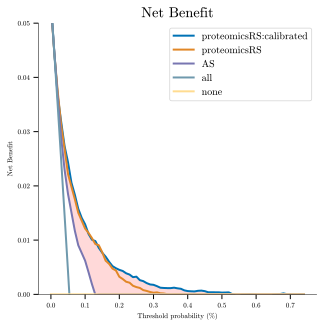

In [260]:
dca_famhistory_df = dca(
    data=test_score,
    outcome="incident_cad",
    modelnames=["proteomicsRS:calibrated", "proteomicsRS", "AS"],
    thresholds=np.arange(0, 0.75, 0.01),
)
# dca_famhistory_df
fig, ax = plt.subplots(figsize=(5, 5))
plot_graphs(
    plot_df=dca_famhistory_df,
    graph_type="net_benefit",
    y_limits=[0, 0.05],
    ax=ax,
    line_kwargs={"lw": 2},
    show_grid=False,
    color_names="nejm",
    smooth_frac=0,
)
ax.set_title("Net Benefit")

y1 = "AS"
y2 = "proteomicsRS:calibrated"

thresholds = [i.get_data()[0] for i in ax.lines if i.get_label() == y1][0]
y1 = [i.get_data()[1] for i in ax.lines if i.get_label() == y1][0]
y2 = [i.get_data()[1] for i in ax.lines if i.get_label() == y2][0]

ax.fill_between(thresholds, y1, y2, color="red", alpha=0.15)
ax.legend(prop={"size": 10})

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xlabel("Threshold probability (%)")
ax.set_ylabel("Net benefit (%)")


# to_plot_region = dca_famhistory_df[dca_famhistory_df["net_benefit"] > 0]

# to_plot_region

In [251]:
y2[0]

array([ 2.50255813e-02,  2.37784215e-02,  2.25344987e-02,  2.12948377e-02,
        2.00609091e-02,  1.88348687e-02,  1.76199330e-02,  1.64209240e-02,
        1.51887649e-02,  1.40886737e-02,  1.30011213e-02,  1.19271272e-02,
        1.08710309e-02,  9.82936702e-03,  8.82482736e-03,  7.96271778e-03,
        7.26371092e-03,  6.63704016e-03,  6.03995612e-03,  5.45197088e-03,
        4.89698912e-03,  4.38515601e-03,  3.96017946e-03,  3.63115051e-03,
        3.32614038e-03,  3.02977996e-03,  2.74553842e-03,  2.47284741e-03,
        2.21587464e-03,  1.98060546e-03,  1.77445650e-03,  1.60210098e-03,
        1.46345216e-03,  1.34952669e-03,  1.25004786e-03,  1.15676158e-03,
        1.06821525e-03,  9.86970101e-04,  9.13138118e-04,  8.44904776e-04,
        7.78666418e-04,  7.11179422e-04,  6.45633113e-04,  5.88929717e-04,
        5.44997641e-04,  5.11537581e-04,  4.81360221e-04,  4.48132927e-04,
        4.05678809e-04,  3.51182498e-04,  2.88242961e-04,  2.24194034e-04,
        1.65413718e-04,  

In [236]:
line1 = ax.lines[0]
line1.get_label()

'proteomicsRS:calibrated'

In [241]:
line1.get_data()[1].shape

(75,)

In [239]:
for i in ax.lines:
    print(i.get_label())

proteomicsRS:calibrated
proteomicsRS
AS
all
none


In [204]:
# dca_famhistory_df["model"].unique()
dca_famhistory_df.query("model == 'proteomicsRS'")

,model,threshold,n,prevalence,harm,test_pos_rate,tp_rate,fp_rate,net_benefit,net_intervention_avoided
75,proteomicsRS,0.00,15432,0.053979,0.0,0.884396,0.053136,0.831260,0.053136,-inf
76,proteomicsRS,0.01,15432,0.053979,0.0,0.815902,0.052164,0.763738,0.044450,0.002657
77,proteomicsRS,0.02,15432,0.053979,0.0,0.738790,0.051387,0.687403,0.037358,0.131610
78,proteomicsRS,0.03,15432,0.053979,0.0,0.653577,0.049896,0.603681,0.031226,0.210342
79,proteomicsRS,0.04,15432,0.053979,0.0,0.568624,0.048471,0.520153,0.026798,0.293675
...,...,...,...,...,...,...,...,...,...,...
145,proteomicsRS,0.70,15432,0.053979,0.0,0.000000,0.000000,0.000000,0.000000,0.922888
146,proteomicsRS,0.71,15432,0.053979,0.0,0.000000,0.000000,0.000000,0.000000,0.923974
147,proteomicsRS,0.72,15432,0.053979,0.0,0.000000,0.000000,0.000000,0.000000,0.925030
148,proteomicsRS,0.73,15432,0.053979,0.0,0.000000,0.000000,0.000000,0.000000,0.926057


In [203]:
dca_famhistory_df.query("model == 'AS'")

,model,threshold,n,prevalence,harm,test_pos_rate,tp_rate,fp_rate,net_benefit,net_intervention_avoided
150,AS,0.00,15432,0.053979,0.0,0.900791,0.053266,0.847525,0.053266,-inf
151,AS,0.01,15432,0.053979,0.0,0.855430,0.052812,0.802618,0.044705,0.027929
152,AS,0.02,15432,0.053979,0.0,0.802229,0.051581,0.750648,0.036262,0.077890
153,AS,0.03,15432,0.053979,0.0,0.751685,0.050544,0.701140,0.028860,0.133834
154,AS,0.04,15432,0.053979,0.0,0.659668,0.048406,0.611262,0.022937,0.201011
...,...,...,...,...,...,...,...,...,...,...
220,AS,0.70,15432,0.053979,0.0,0.000000,0.000000,0.000000,0.000000,0.922888
221,AS,0.71,15432,0.053979,0.0,0.000000,0.000000,0.000000,0.000000,0.923974
222,AS,0.72,15432,0.053979,0.0,0.000000,0.000000,0.000000,0.000000,0.925030
223,AS,0.73,15432,0.053979,0.0,0.000000,0.000000,0.000000,0.000000,0.926057


In [ ]:
sns.lineplot()

## code from jingtai

In [174]:
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


def calculate_net_benefit_model(thresh_group, y_pred_score, y_label):
    net_benefit_model = np.array([])
    for thresh in thresh_group:
        y_pred_label = y_pred_score > thresh
        tn, fp, fn, tp = confusion_matrix(y_label, y_pred_label).ravel()
        n = len(y_label)
        net_benefit = (tp / n) - (fp / n) * (thresh / (1 - thresh))
        net_benefit_model = np.append(net_benefit_model, net_benefit)
    return net_benefit_model


def calculate_net_benefit_all(thresh_group, y_label):
    net_benefit_all = np.array([])
    tn, fp, fn, tp = confusion_matrix(y_label, y_label).ravel()
    total = tp + tn
    for thresh in thresh_group:
        net_benefit = (tp / total) - (tn / total) * (thresh / (1 - thresh))
        net_benefit_all = np.append(net_benefit_all, net_benefit)
    return net_benefit_all


def get_xlim(net_benefit):
    idx = 0
    while np.sum(net_benefit[idx : (idx + 10)]) >= 0.0001:
        idx += 1
    return idx * 0.001

In [175]:
y_test.sum() / y_test.shape[0]

0.05397874546397097

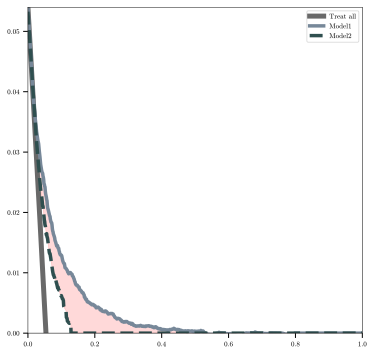

In [183]:
xlim_ubd = 1
fig, ax = plt.subplots(figsize=(6, 6))


thresh_group = np.arange(0, xlim_ubd, 0.001)

net_benefit_all = calculate_net_benefit_all(thresh_group, y_test)
y_all = np.maximum(net_benefit_all, 0)
ax.plot(thresh_group, net_benefit_all, linewidth=5, color="dimgrey", label="Treat all")
ax.set_xlim(0, xlim_ubd)
ax.set_ylim(0, net_benefit_all.max())

# plot proteomics
net_benefit_model1 = calculate_net_benefit_model(
    thresh_group, test_score["proteomicsRS:calibrated"], test_score["incident_cad"]
)
ax.plot(
    thresh_group,
    net_benefit_model1,
    linestyle="solid",
    color="lightslategray",
    linewidth=3.5,
    label="Model1",
)
y1 = np.maximum(net_benefit_model1, 0)

# plot AS

net_benefit_model2 = calculate_net_benefit_model(
    thresh_group, test_score["AS"], test_score["incident_cad"]
)
ax.plot(
    thresh_group,
    net_benefit_model2,
    linestyle="dashed",
    linewidth=3.5,
    color="darkslategrey",
    label="Model2",
)
y2 = np.maximum(net_benefit_model2, y_all)
ax.fill_between(thresh_group, y1, y2, color="red", alpha=0.15)
ax.legend()

In [181]:
thresh_group.shape, y1.shape, y2.shape

((1000,), (1000,), (1000,))

In [ ]:


dpath = '/Volumes/JasonWork/Projects/UKB_Proteomics/Data/'
outpath = '/Volumes/JasonWork/Projects/UKB_Proteomics/Results/'

target_code_df = pd.read_csv(dpath + 'Target_code.csv', encoding='latin-1')
target_code_lst = target_code_df.Disease_code.tolist()
target_label_dict = dict(zip(target_code_lst, target_code_df.Disease.tolist()))


for target_code in target_code_lst:
    xlim_ubd = 1
    mydf0 = pd.read_csv(outpath + 'MLModeling/CPH/PredProbs/ProRS/' + target_code + '.csv')
    mydf1 = pd.read_csv(outpath + 'MLModeling/CPH/PredProbs/AgeSex/' + target_code + '.csv')
    mydf2 = pd.read_csv(outpath + 'MLModeling/CPH/PredProbs/PANEL/' + target_code + '.csv')
    mydf10 = pd.read_csv(outpath + 'MLModeling/CPH/PredProbs/ProRS_AgeSex/' + target_code + '.csv')
    mydf20 = pd.read_csv(outpath + 'MLModeling/CPH/PredProbs/ProRS_PANEL/' + target_code + '.csv')
    fold_id_lst = [ele for ele in range(10)]
    fig, ax = plt.subplots(figsize=(12, 12))
    thresh_group = np.arange(0, xlim_ubd, 0.001)
    net_benefit_all = calculate_net_benefit_all(thresh_group, mydf1.Y)
    y_all = np.maximum(net_benefit_all, 0)
    ax.plot(thresh_group, net_benefit_all, linewidth=5, color='dimgrey', label='Treat all')
    ax.set_xlim(0, xlim_ubd)
    ax.set_ylim(0, net_benefit_all.max())
    net_benefit_model1 = calculate_net_benefit_model(thresh_group, mydf1.CPH_Risk, mydf1.Y)
    ax.plot(thresh_group, net_benefit_model1, linestyle='solid', color='lightslategray', linewidth=3.5, label='Model1')
    y1 = np.maximum(net_benefit_model1, 0)
    net_benefit_model2 = calculate_net_benefit_model(thresh_group, mydf2.CPH_Risk, mydf2.Y)
    ax.plot(thresh_group, net_benefit_model2, linestyle='dashed', linewidth=3.5, color='darkslategrey', label='Model2')
    y2 = np.maximum(net_benefit_model2, y_all)
    ax.fill_between(thresh_group, y1, y2, color='red', alpha=0.15)
    net_benefit_model0 = calculate_net_benefit_model(thresh_group, mydf0.ProRS, mydf0.Y)
    ax.plot(thresh_group, net_benefit_model0, linestyle='solid', linewidth=3.5, color='firebrick', label='Model0')
    y0 = np.maximum(net_benefit_model0, y2)
    ax.fill_between(thresh_group, y0, y2, color='red', alpha=0.15)
    y0 = np.maximum(net_benefit_model0, y1)
    ax.fill_between(thresh_group, y0, y1, color='red', alpha=0.15)
    net_benefit_model10 = calculate_net_benefit_model(thresh_group, mydf10.CPH_Risk, mydf10.Y)
    ax.plot(thresh_group, net_benefit_model10, linestyle='dotted', linewidth=3.5, color='darkslategrey', label='Model10')
    y10 = np.maximum(net_benefit_model10, y0)
    # ax.fill_between(thresh_group, y10, y0, color='purple', alpha=0.2)
    net_benefit_model20 = calculate_net_benefit_model(thresh_group, mydf20.CPH_Risk, mydf20.Y)
    ax.plot(thresh_group, net_benefit_model20, linestyle='solid', linewidth=3.5, color='darkslategrey', label='Model20')
    y20 = np.maximum(net_benefit_model20, y0)
    ax.fill_between(thresh_group, y20, y0, color='lightseagreen', alpha=0.25)
    x_lim1 = get_xlim(net_benefit_model1)
    x_lim2 = get_xlim(net_benefit_model2)
    x_lim0 = get_xlim(net_benefit_model0)
    x_lim10 = get_xlim(net_benefit_model10)
    x_lim20 = get_xlim(net_benefit_model20)
    xlim_ubd_new = np.max((x_lim1, x_lim2, x_lim0, x_lim10, x_lim20))
    if xlim_ubd_new>=0.35:
        xlim_ubd_new = xlim_ubd_new+0.05
    elif (xlim_ubd_new <0.35) & (xlim_ubd_new>0.15):
        xlim_ubd_new = xlim_ubd_new + 0.03
    else:
        xlim_ubd_new = xlim_ubd_new + 0.015
    ax.set_xlim(0, xlim_ubd_new)
    my_lbs = ax.get_xticks().tolist()
    my_lbs1 = [str(int(ele * 100)) for ele in my_lbs]
    ax.set_xticklabels(my_lbs1, fontsize=30)
    ylim_ubd = net_benefit_all.max()
    yax_cut = [ylim_ubd / 5 * i for i in range(6)]
    ax.set_yticks(yax_cut)
    ylbs = [item.get_text() for item in ax.get_yticklabels()]
    ylbs = ['0', '20', '40', '60', '80', '100']
    ax.set_title(target_label_dict[target_code], y=1.0, pad=-36, fontsize=42)
    ax.set_yticklabels(ylbs, fontsize=30)
    ax.spines['top'].set_color('white')
    ax.spines['right'].set_color('white')
    ax.legend().set_visible(False)
    plt.margins(0.0, 0.05)
    plt.tight_layout()
    plt.savefig(outpath + 'SuppData/sFigures/sFigure5/' + target_code + '.png', bbox_inches='tight', pad_inches=0.05)


# Remind to customize codes for breast and prostate cancer